In [2]:
import matplotlib
import matplotlib.pylab as plt
import glob
import numpy
import math
from joblib import Parallel, delayed

# Configuration
RUN_ID = "1"
RUNNING_TIME = 20

In [3]:
def res_dir(rid):
    return "results/" + rid

In [4]:
def process_log(filename):
    print("Processing", filename)

    publications = {}
    latencies = {}
    max_time = 0
    sync_pack = 0
    sync_byte = 0
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                    
                continue
            
            line = [x.strip() for x in line.split(',')]
            
            time = float(line[0])
            node = line[1]
            mtype = line[2]
            mid = line[3]
            
            if mtype == 'PUB':
                publications[mid] = time
            
            if mtype == 'RECV':
                if mid not in latencies:
                    latencies[mid] = []
                latencies[mid].append(time - publications[mid])
                
            max_time = max(max_time, time)
    
    return latencies, max_time, sync_pack, sync_byte

In [5]:
#new log format
method = 'FULL'
grid = '4'
loss = '0'
topology = '6node'
logfiles = glob.glob("exp_log_files_josh/" +
                         method + "_Method-" +
                         topology + '-' +
                         "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
                         "*_Nodes_Pub_Fast-"+
                         "*_RECENT_PUB-" +
                         "*_RANDOM_PUB-10_S_STOP-" +
                         loss + "_DROP_RATE*.log")
print(logfiles)
testOut = process_log(logfiles[0])

logHandler = open("processed_log.txt", "w")
logHandler.write(str(testOut))

['exp_log_files_josh\\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log']
Processing exp_log_files_josh\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log


13284

In [14]:
#original log format
method = 'FULL'
grid = '4'
loss = '0'
logfiles = glob.glob("exp_log_files_josh/" +
                         method + "_Method-" +
                         grid + "_Row-" +
                         grid + "_Col-"+
                         "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
                         "*_Nodes_Pub_Fast-"+
                         "*_RECENT_PUB-" +
                         "*_RANDOM_PUB-10_S_STOP-" +
                         loss + "_DROP_RATE*.log")
print(logfiles)
testOut = process_log(logfiles[0])

logHandler = open("processed_log.txt", "w")
logHandler.write(str(testOut))

['exp_log_files_josh\\FULL_Method-4_Row-4_Col-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log']
Processing exp_log_files_josh\FULL_Method-4_Row-4_Col-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log


13931

In [19]:
def average_delay_for_node(node_of_interest,log_file):
    publications = {}
    latencies = []
    max_time = 0
    with open(log_file, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                continue
            line = [x.strip() for x in line.split(',')]

            time = float(line[0])
            node = line[1]
            mtype = line[2]
            mid = line[3]
            if mtype == 'PUB':
                publications[mid] = time
            if node != node_of_interest:
                continue
            if mtype == 'RECV':
                latencies.append(time - publications[mid])

            max_time = max(max_time, time)
        print(f"Average delay (ms) for node {node_of_interest}: {sum(latencies)/len(latencies)}")

In [82]:
log_file = logfiles[0]
print("Processing", log_file)
for i in range(0,6):
    node_name = f"/participant{i+1}"
    average_delay_for_node(node_name, log_file)
#note: we delay start of node1 publishing by 3 seconds in simulation

Processing exp_log_files_josh\FULL_Method-4_Row-4_Col-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Average delay (ms) for node /participant1: 361.7625242718445
Average delay (ms) for node /participant2: 28.88979797979807
Average delay (ms) for node /participant3: 20.95018181818184
Average delay (ms) for node /participant4: 20.521148514851504
Average delay (ms) for node /participant5: 28.865202020201902
Average delay (ms) for node /participant6: 28.865202020201902


In [16]:
nodeNames = ['Src1', 'Src2', 'Rtr1', 'Rtr2', 'Dst1', 'Dst2']

In [20]:
log_file = logfiles[0]
print("Processing", log_file)
for i in range(0,6):
    # node_name = f"/participant{i+1}"
    node_name = f'/{nodeNames[i]}'
    print(node_name)
    average_delay_for_node(node_name, log_file)
#note: we delay start of node1 publishing by 3 seconds in simulation

Processing exp_log_files_josh\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
/Src1
Average delay (ms) for node /Src1: 329.0246078431372
/Src2
Average delay (ms) for node /Src2: 28.75302020202011
/Rtr1
Average delay (ms) for node /Rtr1: 20.622989999999785
/Rtr2
Average delay (ms) for node /Rtr2: 20.433888888888735
/Dst1
Average delay (ms) for node /Dst1: 28.30321000000005
/Dst2
Average delay (ms) for node /Dst2: 28.304450000000053


In [22]:
def validatedPosition():
    #Testing 6node original positions vs zero positions
    #We validate that x/y Position in topology file has no impact on latency
    method = 'FULL'
    loss = '0'
    top1 = '6nodeV1'
    top2 = '6node_zeroPos'
    log1 = glob.glob("exp_log_files_josh/" +
                            method + "_Method-" +
                            top1 + '-' +
                            "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
                            "*_Nodes_Pub_Fast-"+
                            "*_RECENT_PUB-" +
                            "*_RANDOM_PUB-10_S_STOP-" +
                            loss + "_DROP_RATE*.log")
    log2 = glob.glob("exp_log_files_josh/" +
                            method + "_Method-" +
                            top2 + '-' +
                            "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
                            "*_Nodes_Pub_Fast-"+
                            "*_RECENT_PUB-" +
                            "*_RANDOM_PUB-10_S_STOP-" +
                            loss + "_DROP_RATE*.log")
    logfiles = [log1, log2]
    for i in range(0,2):
        logfile = logfiles[i]
        print(f'Processing latencies for Log:{i}')
        for j in range(0,6):
            # node_name = f"/participant{i+1}"
            node_name = f'/{nodeNames[j]}'
            average_delay_for_node(node_name, log_file)
        #note: we delay start of node1 publishing by 3 seconds in simulation

Processing latencies for Log:0
Average delay (ms) for node /Src1: 329.0246078431372
Average delay (ms) for node /Src2: 28.75302020202011
Average delay (ms) for node /Rtr1: 20.622989999999785
Average delay (ms) for node /Rtr2: 20.433888888888735
Average delay (ms) for node /Dst1: 28.30321000000005
Average delay (ms) for node /Dst2: 28.304450000000053
Processing latencies for Log:1
Average delay (ms) for node /Src1: 329.0246078431372
Average delay (ms) for node /Src2: 28.75302020202011
Average delay (ms) for node /Rtr1: 20.622989999999785
Average delay (ms) for node /Rtr2: 20.433888888888735
Average delay (ms) for node /Dst1: 28.30321000000005
Average delay (ms) for node /Dst2: 28.304450000000053


In [23]:
def add_plot(result_dictionary, label, marker):
    lists = sorted(result_dictionary.items())
    x, y = zip(*lists)
    plt.plot(x, y, label=label, marker=marker)

In [39]:
def set_p(latency_dictionary, max_time, sync_pack, sync_byte):
    results50 = {}
    results90 = {}
    results_pack = {}
    results_byte = {}
    scale = math.sqrt(1) #original author does this
    # I'm assuming this is  to normalize values s.t they have a standard deviation of 1
    nums50 = []
    nums90 = []
    for messageID in latency_dictionary:
        # print(f'messageID (key for latency dic) is {messageID}')
        nums50.append(numpy.percentile(latency_dictionary[messageID], 50))
        nums90.append(numpy.percentile(latency_dictionary[messageID], 90))

    print(f'Max time: {max_time}')
    total_pubs_per_sec = len(latency_dictionary)/(max_time/1000)
    print(f'k is {total_pubs_per_sec}')
    results50[total_pubs_per_sec] = numpy.average(nums50) / scale
    results90[total_pubs_per_sec] = numpy.average(nums90) / scale
    results_pack[total_pubs_per_sec] = sync_pack
    results_byte[total_pubs_per_sec] = sync_byte


    return results50, results90
    # return results90, results50, label, results_pack, results_byte, marker

messageID (key for latency dic) is /participant2::1
messageID (key for latency dic) is /participant3::1
messageID (key for latency dic) is /participant4::1
messageID (key for latency dic) is /participant5::1
messageID (key for latency dic) is /participant6::1
messageID (key for latency dic) is /participant4::2
messageID (key for latency dic) is /participant3::2
messageID (key for latency dic) is /participant2::2
messageID (key for latency dic) is /participant6::2
messageID (key for latency dic) is /participant5::2
messageID (key for latency dic) is /participant3::3
messageID (key for latency dic) is /participant5::3
messageID (key for latency dic) is /participant4::3
messageID (key for latency dic) is /participant6::3
messageID (key for latency dic) is /participant2::3
messageID (key for latency dic) is /participant3::4
messageID (key for latency dic) is /participant6::4
messageID (key for latency dic) is /participant5::4
messageID (key for latency dic) is /participant2::4
messageID (k

C:\Users\joshc\AppData\Local\Temp\ipykernel_21524\1563794196.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


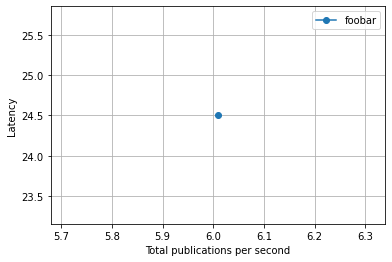

In [81]:
fig = matplotlib.pyplot.gcf()
results50 = set_p(*testOut)
add_plot(results50, label='foobar', marker='o')
plt.xlabel("Total publications per second")
plt.ylabel("Latency")
fig.set_size_inches(6, 2.5)
plt.grid()
plt.legend()
fig.show()

In [51]:
import os
#sort glob files based on rate speed
def get_key(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    partofInterest = filename.split('-')[2]
    intpart = partofInterest.split('_')[0]
    return int(intpart)

Processing exp_log_files_josh\FULL_Method-6node-700_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Max time: 19902.8
k is 8.541511747090862
Processing exp_log_files_josh\FULL_Method-6node-850_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Max time: 19974.8
k is 7.108957286180588
Processing exp_log_files_josh\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Max time: 19773.9
k is 6.068605586151442
Processing exp_log_files_josh\FULL_Method-6node-1150_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Max time: 19789.8
k is 5.356294656843424
Processing exp_log_files_josh\FULL_Method-6node-1300_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Max time: 19874.4


C:\Users\joshc\AppData\Local\Temp\ipykernel_19860\2079888340.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


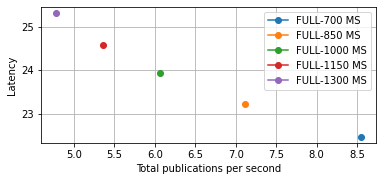

In [56]:

#assuming same topology
topology='6node'
method = 'FULL'
slowRates = ['700', '850', '1000', '1150', '1300']
logs =  glob.glob("exp_log_files_josh/" + method + "_Method-" + topology + '-*')
logs = sorted(logs, key=get_key)
nodeNames = ['Src1', 'Src2', 'Rtr1', 'Rtr2', 'Dst1', 'Dst2']
results = []
for log in logs:
    processedLog = process_log(log)
    results50,results90 = set_p(*processedLog)
    results.append(results50)
fig = matplotlib.pyplot.gcf()
for i in range(0, len(results)):
    # print(results)
    add_plot(results[i], label=f'{method}-{slowRates[i]} MS', marker='o')
plt.xlabel("Total publications per second")
plt.ylabel("Latency")
fig.set_size_inches(6, 2.5)
plt.grid()
plt.legend()
fig.show()

Processing exp_log_files_josh\FULL_Method-butterfly-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Max time: 19993.0
k is 25.408893112589407


C:\Users\joshc\AppData\Local\Temp\ipykernel_19860\3228350051.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


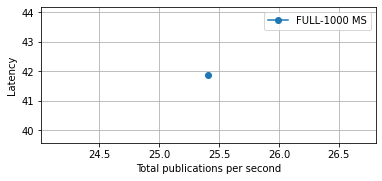

In [58]:

#assuming same topology
topology='butterfly'
method = 'FULL'
slowRates = ['1000']
logs =  glob.glob("exp_log_files_josh/" + method + "_Method-" + topology + '-*')
logs = sorted(logs, key=get_key)
# nodeNames = ['Src1', 'Src2', 'Rtr1', 'Rtr2', 'Dst1', 'Dst2']
results = []
for log in logs:
    processedLog = process_log(log)
    results50,results90 = set_p(*processedLog)
    results.append(results50)
fig = matplotlib.pyplot.gcf()
for i in range(0, len(results)):
    # print(results)
    add_plot(results[i], label=f'{method}-{slowRates[i]} MS', marker='o')
plt.xlabel("Total publications per second")
plt.ylabel("Latency")
fig.set_size_inches(6, 2.5)
plt.grid()
plt.legend()
fig.show()

for the butterfly topology
we know that hopcounts are:
### d1-d2 && d3-d4:5, 
### d1-d3:6, 
### d1-d4 && d2-d3:7
### d2-d4:8

In [69]:
def average_p2p_delay_for_node(src,dest,log_file):
    publications = {}
    latencies = []
    max_time = 0
    with open(log_file, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                continue
            line = [x.strip() for x in line.split(',')]

            time = float(line[0])
            node = line[1] 
            mtype = line[2]
            mid = line[3]
            if mtype == 'PUB' and node == src: 
                publications[mid] = time
                
            if mtype == 'RECV' and node == dest:
                #if msg id of sender matches src, 
                if mid[0:3] == src:
                    latencies.append(time - publications[mid])

            max_time = max(max_time, time)
        print(f"Average delay (ms) for node {src}-{dest}: {sum(latencies)/len(latencies)}")
        return latencies

In [68]:
mid = '/a6::1'
print(mid[0:3])

/a6


In [74]:
#how can we observe the effects of our topology on scalability?
#d1 to d2 latency:

topology='butterfly'
method = 'FULL'
slowRates = ['1000']
logs =  glob.glob("exp_log_files_josh/" + method + "_Method-" + topology + '-*')
logs = sorted(logs, key=get_key)
log_file = logs[0]
print("Processing", log_file)

latencies = average_p2p_delay_for_node('/d1', '/d2', log_file)
#note: we delay start of node1 publishing by 3 seconds in simulation
print(latencies)

d1_d4_latencies = average_p2p_delay_for_node('/d1', '/d4', log_file)
print(d1_d4_latencies)

d4_d1_latencies = average_p2p_delay_for_node('/d4', '/d1', log_file)
print(d4_d1_latencies)

Processing exp_log_files_josh\FULL_Method-butterfly-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Average delay (ms) for node /d1-/d2: 56.35050000000014
[150.28, 51.40000000000009, 51.40000000000009, 51.40000000000009, 51.399999999999636, 51.409999999999854, 51.399999999999636, 51.409999999999854, 51.399999999999636, 51.409999999999854, 51.5, 51.399999999999636, 51.399999999999636, 51.399999999999636, 51.399999999999636, 51.399999999999636, 51.400000000001455, 51.400000000001455, 51.400000000001455, 51.400000000001455]
Average delay (ms) for node /d1-/d4: 76.46400000000006
[170.36, 71.53999999999996, 71.5300000000002, 71.5300000000002, 71.52999999999975, 71.53999999999996, 71.52999999999975, 71.53999999999996, 71.53999999999996, 71.54000000000087, 71.60000000000036, 71.5, 71.5, 71.5, 71.5, 71.5, 71.5, 71.5, 71.5, 71.5]
Average delay (ms) for node /d4-/d1: 76.43399999999988
[170.36, 71.48000000000002, 71.4800000000000